In [26]:
import pandas as pd
import numpy as np
import datetime as dt

# Şimdilik, veriyi direkt olarak 'data' klasöründen okuyormuş gibi varsayalım.
try:
    df = pd.read_csv("C:/Users/safye/Desktop/Customer_Churn_CLV_Project/Customer_Churn_CLV_Project/data/OnlineRetail.csv/OnlineRetail.csv", encoding = 'unicode_escape') 
    print("Veri başarıyla yüklendi.")
    df_copy = df.copy() 
except FileNotFoundError:
    print("HATA: Lütfen dosyanın 'data/Online_Retail.csv' yolunda olduğundan emin olun.")

# İlk kontrolleri tekrar yapalım:
print("\n--- Eksik Değer Kontrolü (isnull) ---")
print(df.isnull().sum())

Veri başarıyla yüklendi.

--- Eksik Değer Kontrolü (isnull) ---
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [27]:
# Temizlik ve Dönüşümler

# 1. Eksik Müşteri ID'lerini Silme
# Toplam 135,080 satırı siliyoruz.
print(f"Başlangıç Müşteri ID NaN Sayısı: {df['CustomerID'].isnull().sum()}")
df.dropna(subset=['CustomerID'], inplace=True) 

Başlangıç Müşteri ID NaN Sayısı: 135080


Neden İptal Edilen İşlemleri Çıkarıyoruz

1= Monetary (M) İçin: 
Müşteri 100 TL'lik bir alışveriş yaptı, sonra bu siparişi iptal etti. Eğer iptal edilen bu işlemi veri setinde bırakırsak, müşterinin toplam harcaması (M) hatalı olarak 100 TL daha fazla görünür. Modelimiz, aslında parayı geri almış bir müşteriyi yüksek değerli sanır.

2= Frequency (F) İçin:
 Aynı şekilde, iptal edilen bir sipariş, müşterinin toplam sipariş sayısını (F) hatalı olarak artırır. Model, aslında vazgeçmiş bir müşteriyi sadık sanabilir.Bu yüzden bu satırları çıkararak sadece tamamlanmış ve ödenmiş gerçek işlemleri saklıyoruz.

In [28]:
# 2. İptal Edilen İşlemleri Çıkarma
df = df[~df["InvoiceNo"].astype(str).str.contains("C", na=False)] 

# 3. Harcama Miktarı Sıfır ve Negatif Olanları Çıkarma
# Hata olarak girilmiş veya anlamsız (sıfır, negatif) miktarları ve fiyatları veri setinden temizleriz.
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# 4. Veri Tipi Dönüşümleri
df["CustomerID"] = df["CustomerID"].astype(int) 

# 5. Monetary (Harcama) Değişkenini Oluşturma (M)
# Müşteri Harcaması = Miktar * Birim Fiyat
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# 6. InvoiceDate (Tarih) Tipini Dönüştürme
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

print("--- Temizlik Başarıyla Tamamlandı ---")
print(f"Toplam Kalan Satır Sayısı: {len(df)}")
print(f"Toplam Tekil Müşteri Sayısı: {df['CustomerID'].nunique()}")

--- Temizlik Başarıyla Tamamlandı ---
Toplam Kalan Satır Sayısı: 397884
Toplam Tekil Müşteri Sayısı: 4338


!!!
Bizim projemizin amacı tahmin yapmaktır: Müşteri A, gelecekte (önümüzdeki 30 gün içinde) bizi terk edecek mi? sorusunu soruyoruz bunun için bir referans zamanı belirlemeliyiz bu referans zamanı da veri setimizin hepsinin en son işlme yaptığı günden bir sonraki gündür. 

In [29]:
import datetime as dt 

# 1. Veri Setindeki En Son İşlem Tarihini Bulma
last_date = df["InvoiceDate"].max()

# 2. Referans Tarihini (Bugün'ü Temsil Eden Tarih) Belirleme
ANALYSIS_DATE = last_date + dt.timedelta(days=1) 
print(f"Analiz Referans Tarihi (Bugün): {ANALYSIS_DATE}")

Analiz Referans Tarihi (Bugün): 2011-12-10 12:50:00


In [30]:
rfm_df = df.groupby('CustomerID').agg({
    # Recency (R): Müşterinin son alışverişinden kaç gün geçtiğini buluruz.Gün olarak.
    "InvoiceDate": lambda InvoiceDate: (ANALYSIS_DATE - InvoiceDate.max()).days,
    
    # Frequency (F): Tekil sipariş sayısı.
    # Müşterinin toplam kaç farklı sipariş verdiğini buluyoruz.
    "InvoiceNo": lambda InvoiceNo: InvoiceNo.nunique(),
    
    # Monetary (M): Toplam harcama. Müşterinin bize kazandırdığı toplam parayı buluruz.
    "TotalPrice": lambda TotalPrice: TotalPrice.sum()
})

rfm_df.columns = ['Recency', 'Frequency', 'Monetary']

print("\n--- RFM Tablosunun İlk 5 Satırı (X Değişkenleri Çekirdeği) ---")
print(rfm_df.head())


--- RFM Tablosunun İlk 5 Satırı (X Değişkenleri Çekirdeği) ---
            Recency  Frequency  Monetary
CustomerID                              
12346           326          1  77183.60
12347             2          7   4310.00
12348            75          4   1797.24
12349            19          1   1757.55
12350           310          1    334.40


Proje tanımımıza göre, müşterinin önümüzdeki 30 gün içinde geri gelip gelmeyeceğini tahmin etmeliyiz.

Geçmiş (X): ANALYSIS_DATE'e kadar olan her şey.

Gelecek (Y): ANALYSIS_DATE'ten sonraki 30 gün.

Bu kod bloğu, müşterinin geçmişteki davranışlarına (RFM/X) bakarak tahmin edeceğimiz gelecekteki durumunu (CHURN/Y) tanımlar ve hesaplar.

In [31]:
# Hücre 5: Kayıp (Y) Değişkenini Oluşturma

# Tahmin yapacağı zaman aralığını belirtiyoruz
# Başlangıç: ANALYSIS_DATE (Örn: 1 Ocak 2012)
target_start_date = ANALYSIS_DATE 
# Bitiş: ANALYSIS_DATE'ten 30 gün sonrası
target_end_date = ANALYSIS_DATE + dt.timedelta(days=30) 

print(f"RFM (X) hesaplandı: {ANALYSIS_DATE} tarihine kadar.")
print(f"Tahmin Penceresi (Y): {target_start_date} ile {target_end_date} arası (30 Gün)")

RFM (X) hesaplandı: 2011-12-10 12:50:00 tarihine kadar.
Tahmin Penceresi (Y): 2011-12-10 12:50:00 ile 2012-01-09 12:50:00 arası (30 Gün)


In [32]:
# 2. 30 Gün İçinde Geri Gelen Müşterileri Bulma (Non-Churn Grubu)

# Sadece hedef zamandaki işlemleri filtrele
target_df = df[(df["InvoiceDate"] >= target_start_date) & (df["InvoiceDate"] < target_end_date)]

# Bu dönemde alışveriş yapan tekil müşteri ID'lerini (Y=0 olanları) listele
loyal_customers = target_df["CustomerID"].unique()

# 3. Y Değişkenini (CHURN) rfm_df'e Ekleme
# Adım A: Varsayılan olarak herkesi Kayıp (1) kabul et
rfm_df["CHURN"] = 1

# Adım B: Hedef dönemde alışveriş yapanları (loyal_customers) Devam (0) olarak güncelle
rfm_df.loc[rfm_df.index.isin(loyal_customers), "CHURN"] = 0

print("\n--- Churn Durumu Dağılımı ---")
# 1 ve 0 sayısını kontrol etme. Bu, modelimizin sınıf dağılımını gösterir.
print(rfm_df["CHURN"].value_counts()) 


--- Churn Durumu Dağılımı ---
CHURN
1    4338
Name: count, dtype: int64


Sınıf Dengesizliği sorunu oluştu:

target_start_date = ANALYSIS_DATE
ANALYSIS_DATE'in kendisi (2011-12-10 12:50:00), veri setindeki son işlemin hemen sonrası olduğu için, ondan sonraki 30 gün içinde kaydedilmiş işlem verisi yok (veya çok az).

target_df = df[...]
Veri seti orada bittiği için, bu filtreleme sonucunda target_df (Gelecekteki İşlemler) tablosu boş çıktı.

loyal_customers = target_df["CustomerID"].unique()
Boş çıkan target_df'ten dolayı, loyal_customers (Devam Eden Müşteriler) listesi de boş oldu.

rfm_df.loc[... , "CHURN"] = 0
Hiç loyal_customers olmadığı için, varsayılan $Y=1$ etiketinden $Y=0$ olarak değiştirilen hiç müşteri olmadı.

In [33]:
# Hücre 6: Final Kontrolü

# RFM değerleri ile CHURN etiketini birleştirmiş final tablomuz
final_df = rfm_df[['Recency', 'Frequency', 'Monetary', 'CHURN']]

print("--- Final Model Veri Seti (X ve Y) ---")
print(final_df.head())

# Kayıp (1) olan müşterilerin Kayıp Olmayan (0) müşterilere oranını kontrol edelim
churn_rate = final_df['CHURN'].value_counts(normalize=True).mul(100).round(2)
print("\n--- Kayıp Oranı (Sınıf Dengesi) ---")
print(churn_rate)

--- Final Model Veri Seti (X ve Y) ---
            Recency  Frequency  Monetary  CHURN
CustomerID                                     
12346           326          1  77183.60      1
12347             2          7   4310.00      1
12348            75          4   1797.24      1
12349            19          1   1757.55      1
12350           310          1    334.40      1

--- Kayıp Oranı (Sınıf Dengesi) ---
CHURN
1    100.0
Name: proportion, dtype: float64


Düzeltme

In [34]:
# Hücre 7: Yeni Simülasyon Noktasını Belirleme

import datetime as dt # Tarih işlemleri için kütüphane

# 1. Veri setinin en son tarihini bulma
simulated_max_date = df["InvoiceDate"].max()

# 2. YENİ Referans Tarihi (Simülasyon Bugünü): En son tarihten 90 gün öncesi
NEW_ANALYSIS_DATE = simulated_max_date - dt.timedelta(days=90)

print(f"Orijinal Son İşlem Tarihi: {simulated_max_date}")
print(f"Yeni Simülasyon Analiz Tarihi (X Hesaplama Sonu): {NEW_ANALYSIS_DATE}")

Orijinal Son İşlem Tarihi: 2011-12-09 12:50:00
Yeni Simülasyon Analiz Tarihi (X Hesaplama Sonu): 2011-09-10 12:50:00


In [35]:
# Hücre 8: Yeni RFM Hesaplama (df_train ile)

# 1. Eğitim verisi setini (RFM'in hesaplanacağı kısım) filtreleme
df_train = df[df["InvoiceDate"] <= NEW_ANALYSIS_DATE]

# 2. Yeni RFM Hesaplama (df_train'i kullanarak)
rfm_df = df_train.groupby('CustomerID').agg({
    # Recency (R): Müşterinin NEW\_ANALYSIS\_DATE tarihine kadar kaç gündür pasif olduğunu hesaplarız.
    "InvoiceDate": lambda x: (NEW_ANALYSIS_DATE - x.max()).days, 
    
    # Frequency (F): Müşterinin toplam kaç farklı sipariş verdiğini buluruz.
    "InvoiceNo": lambda x: x.nunique(),

    # Monetary (M): Müşterinin bize kazandırdığı toplam parayı buluruz.
    "TotalPrice": lambda x: x.sum() # Monetary (M)
})
rfm_df.columns = ['Recency', 'Frequency', 'Monetary']

In [36]:
# Hücre 9: Y (CHURN) Değişkenini Yeniden Tanımlama ve Kontrol

# 1. Tahmin Penceresi: NEW_ANALYSIS_DATE + 30 Gün (modelimiz bu 30 günlük süreç için tahmin yapacaktır.)
target_start_date = NEW_ANALYSIS_DATE
target_end_date = NEW_ANALYSIS_DATE + dt.timedelta(days=30) 

# 2. Hedef pencerede alışveriş yapan müşterileri bulma (Y=0)
target_df = df[(df["InvoiceDate"] > target_start_date) & (df["InvoiceDate"] <= target_end_date)]
loyal_customers = target_df["CustomerID"].unique()

# 3. CHURN etiketini rfm_df'e ekleme
rfm_df["CHURN"] = 1
rfm_df.loc[rfm_df.index.isin(loyal_customers), "CHURN"] = 0

print("--- Yeni Churn Durumu Dağılımı ---")
print(rfm_df["CHURN"].value_counts())
print("\n--- Yeni Kayıp Oranı (Sınıf Dengesi) ---")
print(rfm_df['CHURN'].value_counts(normalize=True).mul(100).round(2))

--- Yeni Churn Durumu Dağılımı ---
CHURN
1    2414
0     956
Name: count, dtype: int64

--- Yeni Kayıp Oranı (Sınıf Dengesi) ---
CHURN
1    71.63
0    28.37
Name: proportion, dtype: float64


Kayıp Riski Tahmini (Sınıflandırma) Modeli Kurulumu :

Hazırlık aşaması bittiğine göre, şimdi proje planımızın ilk ve ana hedefi olan Müşteri Kayıp Riski Tahmini modelini kurmaya ve test etmeye geçiyoruz. Bu bir sınıflandırma problemidir.

Hücre 10: Model Hazırlığı ve Standardizasyon:

Bu adım, modeli eğitmeden önceki son hazırlığı içerir: Veri setini eğitme ve test etme parçalarına ayırma ve değişkenleri ölçeklendirme.

In [37]:
# Hücre 10: Model Hazırlığı ve Standardizasyon

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np 
import pandas as pd 

# 1. X ve Y Değişkenlerini Ayırma
# X: Recency, Frequency, Monetary (Girdiler)
# Y: CHURN (Çıktı/Hedef)
X = rfm_df[['Recency', 'Frequency', 'Monetary']]
Y = rfm_df['CHURN']

# 2. Veriyi Eğitim ve Test Setlerine Bölme
# Verinin %30'u test, %70'i eğitim için ayrılır. 
# Bu, modelin görmediği veri üzerinde test edilmesini sağlar.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
print(f"Eğitim Seti Boyutu (X_train): {len(X_train)}")
print(f"Test Seti Boyutu (X_test): {len(X_test)}")

# 3. Standardizasyon (Ölçeklendirme)
# Monetary gibi büyük değerlerin modeli domine etmesini önlemek için yapılır.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Eğitim setinde ölçekleyiciyi öğren ve uygula
X_test_scaled = scaler.transform(X_test)       # Öğrenilen ölçeği test setine uygula (tekrar fit etme!)

print("\nStandardizasyon Tamamlandı. Model Eğitimi Başlıyor.")

Eğitim Seti Boyutu (X_train): 2359
Test Seti Boyutu (X_test): 1011

Standardizasyon Tamamlandı. Model Eğitimi Başlıyor.


Hücre 11: Model Eğitimi ve Tahmin:

Bu adımda, Lojistik Regresyon modelini kurarız.

In [38]:
# Hücre 11: Lojistik Regresyon Eğitimi ve Tahmin

# 1. Modeli Tanımlama ve Eğitme
# Lojistik Regresyon, sınıflandırma için kullanılır (S veya K gibi ikili sonuçlar).
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train_scaled, Y_train)

# 2. Tahmin
# Modelin, hiç görmediği X_test verisine dayanarak Kayıp Riski tahmini yapmasını sağlıyoruz.
Y_pred = log_model.predict(X_test_scaled)

Hücre 12: Başarı Metriklerini Değerlendirme:

Bu adım, modelimizin tahminlerinin ne kadar güvenilir olduğunu ölçer.

In [39]:
# Hücre 12: Başarı Metrikleri

print("--- Lojistik Regresyon Model Başarı Metrikleri ---")
# Doğruluk (Accuracy)
print(f"Accuracy (Doğruluk): {accuracy_score(Y_test, Y_pred):.4f}")

# Precision (Kesinlik): Modelin 'Kayıp Edecek' dediği müşterilerin GERÇEKTEN kayıp etme oranı.
print(f"Precision (Kesinlik): {precision_score(Y_test, Y_pred):.4f}")

# Recall (Duyarlılık): Gerçekten Kayıp eden müşterilerin ne kadarını model doğru yakaladı (En kritik metrik).
print(f"Recall (Duyarlılık): {recall_score(Y_test, Y_pred):.4f}")

# F1 Skoru: Precision ve Recall'ın dengeli ortalaması.
print(f"F1 Score: {f1_score(Y_test, Y_pred):.4f}")

--- Lojistik Regresyon Model Başarı Metrikleri ---
Accuracy (Doğruluk): 0.7636
Precision (Kesinlik): 0.7783
Recall (Duyarlılık): 0.9474
F1 Score: 0.8545


RFM Segmentasyonuna Geçiş (Değer Analizi) 👑

Kayıp Riski (Churn) analizi tamamlandı. Şimdi projemizin ikinci büyük hedefi olan Müşteri Değer Analizi aşamasına, yani RFM Segmentasyonu'na geçiyoruz.

Bu aşamada amaç, müşterinin sadece Kayıp Riski'ni değil, aynı zamanda şirket için ne kadar değerli olduğunu da anlamaktır.

RFM Skorlarını Hesaplama (1'den 5'e Puanlama)

R, F ve M metriklerini ayrı ayrı 1 (en kötü) ile 5 (en iyi) arasında skorlara dönüştüreceğiz.

R (Recency): En yeni alışverişi yapan (en küçük R) müşteri -> 5 puan almalı.

F (Frequency): En çok alışveriş yapan (en büyük F) müşteri -> 5 puan almalı.

M (Monetary): En çok harcama yapan (en büyük M) müşteri -> 5 puan almalı.

In [40]:
# Hücre 13: RFM Skorlarının Oluşturulması

# RFM Skorları: Recency için düşük değer iyidir, F ve M için yüksek değer iyidir.

# 1. R Skoru (Ters Puanlama: Düşük R değeri (az gün geçti) Yüksek puan (5) alır.)
rfm_df["R_SCORE"] = pd.qcut(rfm_df['Recency'], 5, labels=[5, 4, 3, 2, 1])

# 2. F Skoru (Düz Puanlama: Yüksek F değeri Yüksek puan (5) alır.)
rfm_df["F_SCORE"] = pd.qcut(rfm_df['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

# 3. M Skoru (Düz Puanlama: Yüksek M değeri Yüksek puan (5) alır.)
rfm_df["M_SCORE"] = pd.qcut(rfm_df['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# 4. RFM Skorlarının Birleştirilmesi
# RFM_SCORE: R_SCORE ve F_SCORE'u string olarak birleştirerek RF skorunu oluştururuz.
rfm_df["RFM_SCORE"] = rfm_df["R_SCORE"].astype(str) + rfm_df["F_SCORE"].astype(str)

print("--- RFM Skor Tablosu ---")
print(rfm_df.head())

--- RFM Skor Tablosu ---
            Recency  Frequency  Monetary  CHURN R_SCORE F_SCORE M_SCORE  \
CustomerID                                                                
12346           235          1  77183.60      1       1       1       5   
12347            39          5   2790.86      1       4       4       5   
12348           158          3   1487.24      0       2       4       4   
12350           219          1    334.40      1       1       1       2   
12352           171          5   1561.81      0       1       4       4   

           RFM_SCORE  
CustomerID            
12346             11  
12347             44  
12348             24  
12350             11  
12352             14  


Bu kodlar, her müşteriye ait $\text{R}$ (Yenilik) ve $\text{F}$ (Sıklık) skorlarını (Örn: $54$) alarak, onları uygun bir segment adıyla eşleştirir.

In [41]:
# Hücre 14: Segment İsimlerini Atama

# 1. Segmentlerin Tanımlanması (Örn: 55, 54, 44, 45 -> Şampiyonlar)
seg_map = {
    r'[1-2][1-2]': 'Hibernating_Kayıp_Riski', # R=1,2 F=1,2 (Çoktan Soğumuş ve Tekrarlamayanlar)
    r'[1-2][3-4]': 'At_Risk_Yüksek_Risk',     # R=1,2 F=3,4 (Yeni soğumuş ama çok alışveriş yapmışlar)
    r'[1-2]5': 'Cannot_Lose_Kaybetme_Lüksü_Yok', # R=1,2 F=5 (En sadıklar, ama soğumuşlar, acil kurtarılmalı)
    r'3[1-2]': 'About_to_Sleep_Uyumak_Üzere',  # R=3 F=1,2 (Orta yenilikte, düşük sıklık)
    r'33': 'Need_Attention_İlgiye_Muhtaç',     # R=3 F=3 (Ortalama her şey)
    r'[3-4][4-5]': 'Loyal_Sadık_Müşteriler',    # R=3,4 F=4,5 (İyi sıklık, iyi yenilik)
    r'41': 'Promising_Potansiyel',             # R=4 F=1 (Yeni ve düşük sıklıkta, potansiyel var)
    r'51': 'New_Customers_Yeni_Müşteriler',    # R=5 F=1 (En yeni, tek alışverişli)
    r'[4-5][2-3]': 'Potential_Potansiyel',      # R=4,5 F=2,3 (İyi yenilik, orta/düşük sıklık)
    r'5[4-5]': 'Champions_Şampiyonlar'         # R=5 F=4,5 (En yeni ve en sık alışveriş yapanlar)
}

# 2. RFM_SCORE'a göre Segment İsimlerini Atama
# regex=True, map fonksiyonunun metin kalıplarını (seg_map) kullanmasını sağlar.
rfm_df["Segment"] = rfm_df["RFM_SCORE"].replace(seg_map, regex=True)

print("--- RFM Segment Dağılımı ---")
# Segmentlerin sayısını ve oranını kontrol etme
print(rfm_df["Segment"].value_counts(normalize=True).mul(100).round(2))
print("\n--- Nihai RFM Tablosu (Segmentler) ---")
print(rfm_df[["Segment", "Recency", "Frequency", "Monetary", "CHURN"]].head(10))

--- RFM Segment Dağılımı ---
Segment
Hibernating_Kayıp_Riski           26.68
Loyal_Sadık_Müşteriler            19.61
Champions_Şampiyonlar             15.13
At_Risk_Yüksek_Risk               12.17
Potential_Potansiyel               9.79
About_to_Sleep_Uyumak_Üzere        6.20
Need_Attention_İlgiye_Muhtaç       5.37
Promising_Potansiyel               2.26
New_Customers_Yeni_Müşteriler      1.63
Cannot_Lose_Kaybetme_Lüksü_Yok     1.16
Name: proportion, dtype: float64

--- Nihai RFM Tablosu (Segmentler) ---
                                Segment  Recency  Frequency  Monetary  CHURN
CustomerID                                                                  
12346           Hibernating_Kayıp_Riski      235          1  77183.60      1
12347            Loyal_Sadık_Müşteriler       39          5   2790.86      1
12348               At_Risk_Yüksek_Risk      158          3   1487.24      0
12350           Hibernating_Kayıp_Riski      219          1    334.40      1
12352               At_Risk_

CLV Modeli Kütüphanelerini Yükleme:

Bu kütüphaneler, klasik makine öğrenimi kütüphanelerinden farklıdır, çünkü müşteri satın alma davranışının olasılıksal (probabilistic) modellerini kullanırlar.

Yüklenecek Kütüphaneler:

lifetimes (Ana CLV Kütüphanesi): Müşteri Yaşam Boyu Değeri (CLV) modellemesi için endüstri standardı olan Python kütüphanesidir.

BetaGeoFitter (BG/NBD Modeli): Müşterilerin ne zaman tekrar alışveriş yapacağını ve kayıp riskini aynı anda modelleyen ana modeldir.

GammaGammaFitter (GG Modeli): Tekrar alışveriş yapan müşterilerin ne kadar harcayacağını modelleyen yapıdır.

summary_data_from_transaction_data (Veri Hazırlama Aracı): Ham işlem verisini, CLV modellerinin istediği özel formata (R, F, T, M metrikleri) çeviren kullanışlı fonksiyondur.

In [42]:
# Hücre 15: CLV Modeli Hazırlığı ve Kütüphaneler

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
import datetime as dt # Tarih işlemleri için
import pandas as pd # Veri manipülasyonu için

Ne Yaptık? 

Ham işlem verisini (yüzlerce satırlık faturalar) alıp, her müşteri için CLV modelinin istediği 4 özel zaman ve para metriğini içeren, temiz, müşteri bazlı bir özet tablo (clv_df) oluşturduk.

Neden Yaptık? (Amaç)

Önceki RFM analizimiz (R, F, M), müşterileri segmentlere ayırmak içindi. CLV modelimiz ise ($\text{BG/NBD}$ gibi), müşterilerin gelecekteki satın alma alışkanlıklarının olasılığını hesaplar. Bu olasılık modelinin çalışması için, müşterinin yaşını ve tekrar etme sıklığını tam olarak gösteren $r, f, T$ metriklerine ihtiyacımız vardı.

In [43]:
# Hücre 16: CLV Temel Veri Seti (r, f, T, m)

# 1. Analiz Tarihini Belirleme
max_date = df["InvoiceDate"].max()
ANALYSIS_DATE = max_date + dt.timedelta(days=1)

# 2. summary_data_from_transaction_data ile CLV metriklerini hesaplama.
clv_df = summary_data_from_transaction_data(df, 
                                            customer_id_col='CustomerID', 
                                            datetime_col='InvoiceDate', 
                                            monetary_value_col='TotalPrice',
                                            observation_period_end=ANALYSIS_DATE)

# 3. Monetary değerini güncelleme: Ortalama işlem başına harcamaya çevirme
# Amacı: Modelin, "Bu müşteri tekrar gelirse, ortalama kaç TL harcayacak?" sorusunu yanıtlamasına yardımcı olacak doğru veriyi sağlamaktır.
clv_df['monetary_value'] = clv_df['monetary_value'] / clv_df['frequency']

# 4. Frequency sıfır olan müşterileri temizleme (F>0 olmalı)
clv_df = clv_df[clv_df["frequency"] > 0]

print("--- CLV Temel Veri Seti (r, f, T, m) ---")
print(clv_df.head())

--- CLV Temel Veri Seti (r, f, T, m) ---
            frequency  recency      T  monetary_value
CustomerID                                           
12347             6.0    365.0  368.0       99.950278
12348             3.0    283.0  359.0      100.493333
12352             6.0    260.0  297.0       61.376111
12356             2.0    303.0  326.0      134.952500
12358             1.0    149.0  151.0      683.200000


BG/NBD Modeli Eğitimi ve Kalibrasyonu 

BG/NBD modeli, bize iki temel olasılık cevabı verir:

Gelecekteki İşlem Sayısı: Bir müşteri, belirli bir zaman diliminde (Örn: 3 ay) kaç kez daha alışveriş yapacak?

Hala Aktif Olma Olasılığı: Bir müşteri, şu anda $\text{hala aktif}$ mi yoksa $\text{bizi terk etti}$ mi?

In [44]:
# Hücre 17: BG/NBD Modeli Eğitimi (Gelecekteki İşlem Sayısını Tahmin Eder)

# 1. BG/NBD Modelini Tanımlama
bgf = BetaGeoFitter(penalizer_coef=0.001)

# 2. Modeli Eğitme (r, f, T metriklerini kullanır)
# r, f, T metriklerini clv_df'den çekiyoruz.
bgf.fit(clv_df['frequency'], 
        clv_df['recency'], 
        clv_df['T'])

print("--- BG/NBD Model Parametreleri ---")
print(bgf.summary)

--- BG/NBD Model Parametreleri ---
             coef  se(coef)  lower 95% bound  upper 95% bound
r        1.893004  0.067851         1.760017         2.025991
alpha  106.525241  4.237304        98.220125       114.830357
a        0.009203  0.004463         0.000454         0.017951
b        0.165842  0.083930         0.001339         0.330344


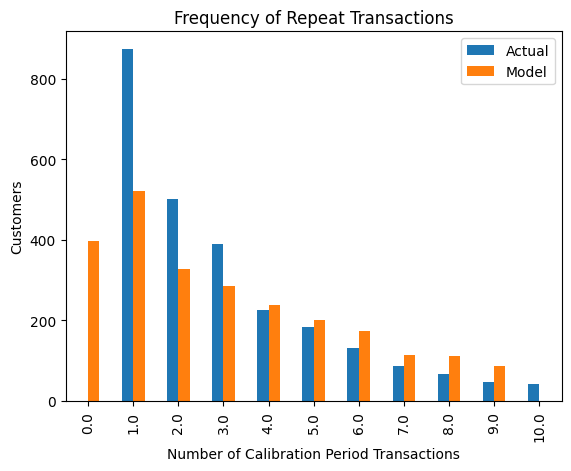

In [45]:
# Hücre 18: BG/NBD Modelinin Görsel Kalibrasyonu

from lifetimes.plotting import plot_period_transactions
import matplotlib.pyplot as plt # Görselleştirme kütüphanesi

# 1. Modelin Görsel Kalibrasyonu
# plot_period_transactions, modelin geçmişteki ortalama işlem sayılarını ne kadar doğru tahmin ettiğini gösterir.
# max_frequency=10, grafikteki karmaşayı azaltmak için en fazla 10 alışveriş sıklığına sahip müşterileri gösterir.
plot_period_transactions(bgf, max_frequency=10)
plt.show()

Hücre 19 - Gelecekteki İşlem Sayısını Tahmin Etme 

Bu adımda, BG/NBD modelinin ana gücünü kullanıyoruz: Müşterinin $r, f, T$ geçmişine bakarak, gelecekteki belirli bir dönemde kaç kez daha alışveriş yapacağını tahmin etmek.

In [46]:
# Hücre 19: Gelecekteki İşlem Sayısını Tahmin Etme

# 6 aylık (180 günlük) dönemde tahmini işlem sayısını hesapla.
t = 180 
# Müşteri başına tahmini işlem sayısını hesaplama
clv_df['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t, 
    clv_df['frequency'], 
    clv_df['recency'], 
    clv_df['T']
)

print(f"--- Önümüzdeki {t} Gün İçin Tahmini İşlem Sayısı (En Yüksek 10) ---")
print(clv_df.sort_values(by="predicted_purchases", ascending=False).head(10))

--- Önümüzdeki 180 Gün İçin Tahmini İşlem Sayısı (En Yüksek 10) ---
            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
14911           131.0    372.0  374.0        8.348562            49.696206
12748           112.0    373.0  374.0        2.687722            42.591597
17841           111.0    372.0  374.0        3.283353            42.216406
15311            89.0    373.0  374.0        7.614938            33.989469
14606            88.0    372.0  374.0        1.544206            33.614580
12971            70.0    369.0  373.0        2.274447            26.936943
13089            65.0    367.0  370.0       13.749451            25.221606
14527            53.0    367.0  370.0        2.924838            20.696172
13798            52.0    371.0  373.0       13.589442            20.192669
16422            47.0    352.0  370.0       14.946220            18.414321


Sonuç: $\text{Gamma-Gamma}$ modelinin temel varsayımı olan bağımsızlık kuralı, veri setimizde geçerlidir. Modelin tahminlerine güvenerek devam edebiliriz.

Çıktı Değeri İçin:

Bu değer, $-0.1$ ile $+0.1$ arasındaki çok zayıf bir ilişkiyi gösterir. Hatta negatif olması, çok sık alışveriş yapanların ortalama sepet değerinin hafifçe daha düşük olduğunu gösterir ki bu, doğal bir e-ticaret davranışıdır. En önemlisi, bu korelasyon neredeyse sıfırdır.

In [47]:
# Hücre 20: Gamma-Gamma Modeli Eğitimi (Ortalama İşlem Değerini Tahmin Eder)

# 1. Gamma-Gamma Ön Şart Kontrolü
# Kontrol: Monetary (Ortalama Harcama) ve Frequency (Sıklık) arasında korelasyon olmamalıdır.
# Eğer korelasyon 0.1'in altındaysa model kullanılabilir.
print(f"Monetary ve Frequency Korelasyonu: {clv_df[['monetary_value', 'frequency']].corr().iloc[0, 1]:.2f}")

# 2. Gamma-Gamma Modelini Tanımlama ve Eğitme (Monetary ve Frequency'yi kullanır)
ggf = GammaGammaFitter(penalizer_coef=0.01)

# Modeli Eğitme (monetary_value ve frequency metriklerini kullanır)
ggf.fit(clv_df['frequency'], 
        clv_df['monetary_value'])

print("\n--- Gamma-Gamma Model Parametreleri ---")
print(ggf.summary)

Monetary ve Frequency Korelasyonu: -0.03

--- Gamma-Gamma Model Parametreleri ---
       coef  se(coef)  lower 95% bound  upper 95% bound
p  3.639979  0.090695         3.462217         3.817741
q  0.460591  0.010186         0.440627         0.480555
v  3.497772  0.091665         3.318108         3.677436


Nihai CLV Tahmini 👑

Bu kod bloğunun temel amacı: BG/NBD modelinden gelen işlem sayısını, Gamma-Gamma modelinden gelen ortalama harcama değeriyle çarparak, her müşterinin şirket için gelecekteki tahmini toplam değerini (CLV) hesaplamaktır.

In [48]:
# Hücre 21: Müşteri Yaşam Boyu Değeri (CLV) Tahmini

# BG/NBD ve Gamma-Gamma tahminlerini birleştirerek CLV'yi hesapla.
# Tahmin periyodunu BG/NBD tahminindeki t=180 gün olarak varsayıyoruz.

clv_df['expected_average_profit'] = ggf.conditional_expected_average_profit(
    clv_df['frequency'], 
    clv_df['monetary_value']
)

# Nihai CLV = Tahmini İşlem Sayısı (BG/NBD) * Tahmini Ortalama Kar (GG)
clv_df['CLV'] = clv_df['predicted_purchases'] * clv_df['expected_average_profit']


print("--- Önümüzdeki 6 Ay İçin EN YÜKSEK CLV Tahmini (En Değerli Müşteriler) ---")
print(clv_df.sort_values(by="CLV", ascending=False).head(10))

--- Önümüzdeki 6 Ay İçin EN YÜKSEK CLV Tahmini (En Değerli Müşteriler) ---
            frequency  recency      T  monetary_value  predicted_purchases  \
CustomerID                                                                   
16446             1.0    205.0  206.0       168469.60             1.567976   
12536             1.0     16.0   60.0         8322.12             2.729125   
15749             1.0     97.0  333.0        21535.90             0.778413   
13868             1.0     31.0   39.0         2685.00             3.323783   
18139             1.0      1.0   19.0         1825.74             3.773579   
16986             1.0      1.0   31.0         1790.00             3.365090   
12762             1.0     18.0   26.0         1436.93             3.643900   
16240             1.0     53.0   78.0         1894.01             2.578610   
12435             1.0    188.0  268.0         3850.90             1.244406   
12438             1.0    126.0  141.0         2016.78             1

Proje Sonuçlarının Genel Yorumu (Aksiyon Planı)

Bu $\text{CLV}$ tahmini, projenin en önemli çıktısıdır ve doğrudan bütçe kararlarını etkiler:

Hedefleme Prioritesi: Şirket, pazarlama bütçesini artık sadece $\text{Kayıp Riski}$ altında olanlara değil, yüksek CLV'ye sahip müşterilere (Örn: 16446, 12536) öncelik vererek harcamalıdır.

Kayıp Önleme Stratejisi: Eğer yüksek $\text{CLV}$'ye sahip bir müşteri (Örn: 12536) aynı zamanda $\text{Lojistik Regresyon}$ modeline göre $\text{CHURN}=1$ (Kayıp Riski) etiketine sahipse, bu müşteriyi $\text{kaybetmemek için derhal çok agresif bir kurtarma kampanyası başlatılmalıdır.}$

Uç Değer Yönetimi: Müşteri 16446 gibi uç değerler, genellikle özel ilgi gerektirir. Bu müşteriler için otomatik promosyonlar yerine, kişisel hesap yöneticisi atanması gibi özel yaklaşımlar düşünülmelidir.

In [51]:
print(rfm_df.columns)

Index(['Recency', 'Frequency', 'Monetary', 'CHURN', 'R_SCORE', 'F_SCORE',
       'M_SCORE', 'RFM_SCORE', 'Segment', 'CLV'],
      dtype='object')


Nihai Segment Raporu Detaylı Açıklaması 👑

Bu hücrenin temel amacı, Kayıp Riski (CHURN), RFM Segmentasyonu ve Müşteri Yaşam Boyu Değeri (CLV) tahmininden elde edilen tüm bilgileri toplayarak, yönetimin direkt aksiyon alabileceği bir özet rapor oluşturmaktır.

In [ ]:
# Hücre 22: Nihai Veri Seti ve Raporlama (KESİN ÇÖZÜM)

# 1. Merge Hatalarını Önleme: CLV sütununu (varsa) sil
# axis=1 (Sütunlar) Anlamı: İşlemi sütunlar üzerinde yap.
if 'CLV' in rfm_df.columns:
    rfm_df = rfm_df.drop('CLV', axis=1) 

# 2. CLV değerlerini ana RFM tablosuna ekleme
rfm_df = rfm_df.merge(clv_df[['CLV']], left_index=True, right_index=True, how='left')

# 3. CLV değeri NaN olanları 0 ile doldurma (Tekil alıcılar)
rfm_df['CLV'] = rfm_df['CLV'].fillna(0)

# 4. Müşteri segmentlerini CLV'ye göre gruplama ve özetleme
final_report = rfm_df.groupby("Segment").agg({
    "CLV": "sum",
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean",
    "CHURN": "mean",
    "Recency": "count" # DÜZELTME: Recency sütununu sayarak müşteri sayısını buluyoruz.
}).rename(columns={"Recency": "Count", "CHURN": "Churn_Rate"}) # Sayım yapılan Recency sütununa 'Count' adını veriyoruz.

# 5. CLV'ye göre en değerli segmentleri sırala
final_report = final_report.sort_values(by="CLV", ascending=False)

print("--- CLV Bazında En Değerli Müşteri Segmentleri Raporu ---")
print(final_report)

--- CLV Bazında En Değerli Müşteri Segmentleri Raporu ---
                                          CLV  Count  Frequency     Monetary  \
Segment                                                                        
Hibernating_Kayıp_Riski         471900.074992    899   1.000000   408.087108   
Loyal_Sadık_Müşteriler          185506.636493    661   5.237519  2178.063828   
Champions_Şampiyonlar           153382.920699    510   9.888235  5366.784531   
At_Risk_Yüksek_Risk             132555.941610    410   2.419512   940.059198   
Potential_Potansiyel            127393.404117    330   1.657576   633.303909   
About_to_Sleep_Uyumak_Üzere      60375.666149    209   1.000000   350.168852   
Need_Attention_İlgiye_Muhtaç     58863.251492    181   1.983425   617.090718   
Promising_Potansiyel             29160.719336     76   1.000000   516.031974   
New_Customers_Yeni_Müşteriler    22298.669154     55   1.000000   343.661455   
Cannot_Lose_Kaybetme_Lüksü_Yok    8688.672269     39   6.76923